In [1]:
# import all necessary libraries
!pip install mysql-connector-python
!pip install vaderSentiment
!pip install tensorflow
!pip install keras
!pip install protobuf
!pip install grpcio
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import pandas as pd
import numpy as np
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow
import keras
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import time
import json
import re
import math
import pickle
from datetime import datetime
from datetime import timedelta
import requests
from requests.auth import AuthBase
import config
import tools
import mysql.connector
import urllib.parse
from mysql.connector import errorcode
import sqlite3
%matplotlib inline
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)

Using TensorFlow backend.


In [30]:
# reload from pickle checkpoint
with open('pickle-folder/tsla_week1_data.pkl', 'rb') as f:
    data = pickle.load(f)
data.head(1000)

,avg_price,compound_sentiment,tweet_count,trade_volume
0,,,,
2020-05-11 05:01:00,819.42000,0.510600,1.0,0.0
2020-05-11 05:02:00,819.42000,0.421500,1.0,0.0
2020-05-11 05:03:00,819.42000,0.421500,0.0,0.0
2020-05-11 05:04:00,819.42000,0.843600,1.0,0.0
2020-05-11 05:05:00,819.42000,-0.125000,2.0,0.0
2020-05-11 05:06:00,819.42000,-0.458800,1.0,0.0
2020-05-11 05:07:00,819.42000,-0.699700,1.0,0.0
2020-05-11 05:08:00,819.42000,0.000000,1.0,0.0
2020-05-11 05:09:00,819.42000,-0.661500,1.0,0.0


# LSTM
- 50-dimensionial single layer
- activation = tanh
- epochs = 20
- batch size = 63
- 2 nights and 2 days of predictions

(3540, 1080) 3540 (3540,)
(3540, 270, 4) (3540,) (2610, 270, 4) (2610,)
Epoch 1/20
56/56 - 6s - loss: 0.0156 - val_loss: 0.0064
Epoch 2/20
56/56 - 5s - loss: 0.0055 - val_loss: 0.0056
Epoch 3/20
56/56 - 5s - loss: 0.0037 - val_loss: 0.0057
Epoch 4/20
56/56 - 5s - loss: 0.0023 - val_loss: 0.0049
Epoch 5/20
56/56 - 5s - loss: 0.0016 - val_loss: 0.0036
Epoch 6/20
56/56 - 5s - loss: 0.0013 - val_loss: 0.0024
Epoch 7/20
56/56 - 5s - loss: 0.0011 - val_loss: 0.0015
Epoch 8/20
56/56 - 5s - loss: 9.5743e-04 - val_loss: 8.6491e-04
Epoch 9/20
56/56 - 5s - loss: 9.5609e-04 - val_loss: 5.7482e-04
Epoch 10/20
56/56 - 5s - loss: 0.0010 - val_loss: 4.3741e-04
Epoch 11/20
56/56 - 6s - loss: 0.0011 - val_loss: 3.5449e-04
Epoch 12/20
56/56 - 6s - loss: 0.0011 - val_loss: 3.0167e-04
Epoch 13/20
56/56 - 5s - loss: 9.9814e-04 - val_loss: 2.7455e-04
Epoch 14/20
56/56 - 5s - loss: 9.3374e-04 - val_loss: 2.6206e-04
Epoch 15/20
56/56 - 5s - loss: 8.7946e-04 - val_loss: 2.5513e-04
Epoch 16/20
56/56 - 6s - loss:

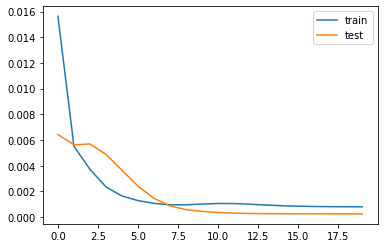

Test RMSE: 1.183
Test RMSE/std_dev: 0.160
Test MAE: 0.682


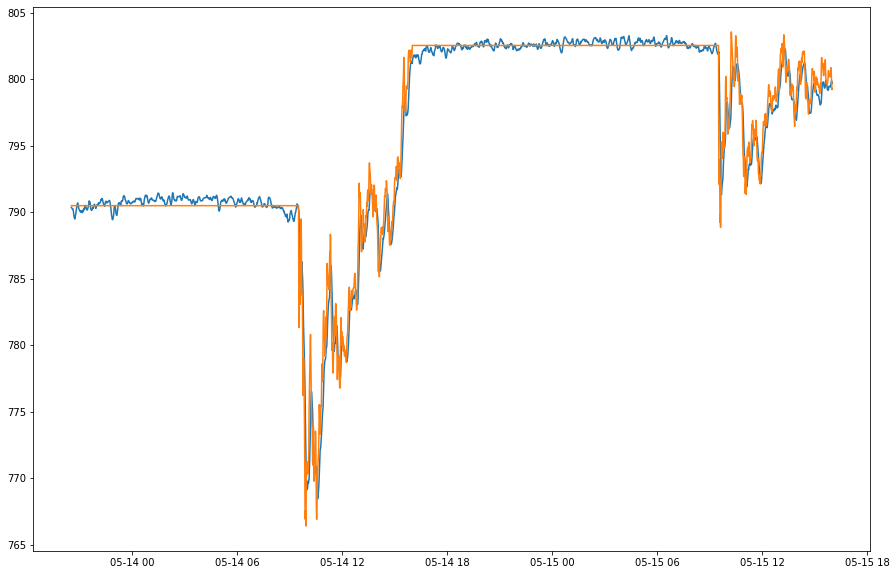

In [88]:
# load dataset
values = data.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# specify the number of lag hours
window = 270
features = 4
# frame as supervised learning
reframed = tools.series_to_supervised(scaled, window, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[-3,-2,-1]], axis=1, inplace=True)

# split into train and test sets
values = reframed.values
train_mins = len(data.loc[:'2020-05-13 16:00:00'])
train = values[:train_mins, :]
test = values[train_mins:, :]
# split into input and outputs
observations = window * features
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], window, features))
test_X = test_X.reshape((test_X.shape[0], window, features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = tensorflow.keras.Sequential()
model.add(tensorflow.keras.layers.LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(tensorflow.keras.layers.Dense(1))
model.compile(loss='mse', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=20, batch_size=64, validation_data=(test_X, test_y), verbose=2, shuffle=False, workers=4)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# make a prediction
y_pred = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], observations))
# invert scaling for forecast
y_pred = np.concatenate((y_pred, test_X[:, -3:]), axis=1)
y_pred = scaler.inverse_transform(y_pred)
y_pred = y_pred[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
y_actual = np.concatenate((test_y, test_X[:, -3:]), axis=1)
y_actual = scaler.inverse_transform(y_actual)
y_actual = y_actual[:,0]
# calculate RMSE
rmse = math.sqrt(mean_squared_error(y_actual, y_pred))
print('Test RMSE: %.3f' % rmse)
rmse_std = rmse/y_actual.std()
print('Test RMSE/std_dev: %.3f' % rmse_std)
mae = mean_absolute_error(y_actual, y_pred)
print('Test MAE: %.3f' % mae)

fig, ax = plt.subplots(1, figsize=(15,10))
plt.plot(data.index[-2610:], y_pred)
plt.plot(data.index[-2610:], y_actual)

 # LSTM
 - 64-dimensional single layer
 - activation=tanh
 - epochs = 20
 - batch size = 64
 - 2 nights and 2 days of predictions

(3540, 1080) 3540 (3540,)
(3540, 270, 4) (3540,) (2610, 270, 4) (2610,)
Epoch 1/20
56/56 - 7s - loss: 0.0351 - val_loss: 0.0132
Epoch 2/20
56/56 - 6s - loss: 0.0078 - val_loss: 0.0082
Epoch 3/20
56/56 - 6s - loss: 0.0056 - val_loss: 0.0067
Epoch 4/20
56/56 - 6s - loss: 0.0035 - val_loss: 0.0060
Epoch 5/20
56/56 - 6s - loss: 0.0023 - val_loss: 0.0049
Epoch 6/20
56/56 - 6s - loss: 0.0017 - val_loss: 0.0037
Epoch 7/20
56/56 - 6s - loss: 0.0013 - val_loss: 0.0025
Epoch 8/20
56/56 - 6s - loss: 9.9832e-04 - val_loss: 0.0016
Epoch 9/20
56/56 - 6s - loss: 8.3761e-04 - val_loss: 9.8806e-04
Epoch 10/20
56/56 - 6s - loss: 7.6575e-04 - val_loss: 6.3225e-04
Epoch 11/20
56/56 - 6s - loss: 7.5978e-04 - val_loss: 4.7279e-04
Epoch 12/20
56/56 - 6s - loss: 7.9279e-04 - val_loss: 4.0944e-04
Epoch 13/20
56/56 - 6s - loss: 8.3833e-04 - val_loss: 3.7700e-04
Epoch 14/20
56/56 - 5s - loss: 8.7298e-04 - val_loss: 3.4841e-04
Epoch 15/20
56/56 - 6s - loss: 8.8269e-04 - val_loss: 3.2093e-04
Epoch 16/20
56/56 - 6s

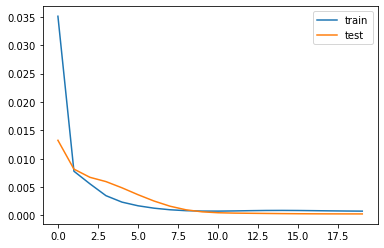

Test RMSE: 1.238
Test RMSE/std_dev: 0.167
Test MAE: 0.747


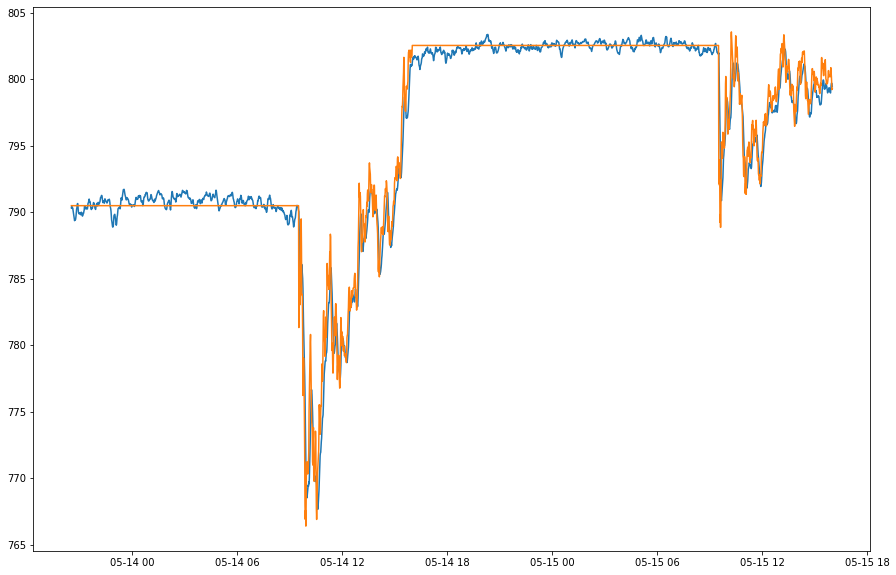

In [98]:
# load dataset
values = data.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# specify the number of lag hours
window = 270
features = 4
# frame as supervised learning
reframed = tools.series_to_supervised(scaled, window, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[-3,-2,-1]], axis=1, inplace=True)

# split into train and test sets
values = reframed.values
train_mins = len(data.loc[:'2020-05-13 16:00:00'])
train = values[:train_mins, :]
test = values[train_mins:, :]
# split into input and outputs
observations = window * features
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], window, features))
test_X = test_X.reshape((test_X.shape[0], window, features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = tensorflow.keras.Sequential()
model.add(tensorflow.keras.layers.LSTM(64, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(tensorflow.keras.layers.Dense(1))
model.compile(loss='mse', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=20, batch_size=64, validation_data=(test_X, test_y), verbose=2, shuffle=False, workers=4)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# make a prediction
y_pred = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], observations))
# invert scaling for forecast
y_pred = np.concatenate((y_pred, test_X[:, -3:]), axis=1)
y_pred = scaler.inverse_transform(y_pred)
y_pred = y_pred[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
y_actual = np.concatenate((test_y, test_X[:, -3:]), axis=1)
y_actual = scaler.inverse_transform(y_actual)
y_actual = y_actual[:,0]
# calculate RMSE
rmse = math.sqrt(mean_squared_error(y_actual, y_pred))
print('Test RMSE: %.3f' % rmse)
rmse_std = rmse/y_actual.std()
print('Test RMSE/std_dev: %.3f' % rmse_std)
mae = mean_absolute_error(y_actual, y_pred)
print('Test MAE: %.3f' % mae)

fig, ax = plt.subplots(1, figsize=(15,10))
plt.plot(data.index[-2610:], y_pred)
plt.plot(data.index[-2610:], y_actual)

# LSTM
- 64-dimensional single layer
- activation=tanh
- epochs = 20
- batch size = 64
- 2 nights and 3 days of predictioins

(3060, 1080) 3060 (3060,)
(3060, 270, 4) (3060,) (3090, 270, 4) (3090,)
Epoch 1/20
48/48 - 6s - loss: 0.0214 - val_loss: 0.0060
Epoch 2/20
48/48 - 6s - loss: 0.0024 - val_loss: 0.0066
Epoch 3/20
48/48 - 6s - loss: 0.0019 - val_loss: 0.0042
Epoch 4/20
48/48 - 6s - loss: 0.0014 - val_loss: 0.0019
Epoch 5/20
48/48 - 5s - loss: 0.0011 - val_loss: 8.8760e-04
Epoch 6/20
48/48 - 6s - loss: 8.7867e-04 - val_loss: 6.3801e-04
Epoch 7/20
48/48 - 6s - loss: 8.1361e-04 - val_loss: 5.9341e-04
Epoch 8/20
48/48 - 6s - loss: 7.9775e-04 - val_loss: 6.3397e-04
Epoch 9/20
48/48 - 6s - loss: 8.2544e-04 - val_loss: 7.7157e-04
Epoch 10/20
48/48 - 6s - loss: 9.0956e-04 - val_loss: 0.0010
Epoch 11/20
48/48 - 6s - loss: 0.0011 - val_loss: 0.0015
Epoch 12/20
48/48 - 6s - loss: 0.0013 - val_loss: 0.0021
Epoch 13/20
48/48 - 5s - loss: 0.0014 - val_loss: 0.0027
Epoch 14/20
48/48 - 5s - loss: 0.0014 - val_loss: 0.0029
Epoch 15/20
48/48 - 5s - loss: 0.0014 - val_loss: 0.0029
Epoch 16/20
48/48 - 5s - loss: 0.0014 - va

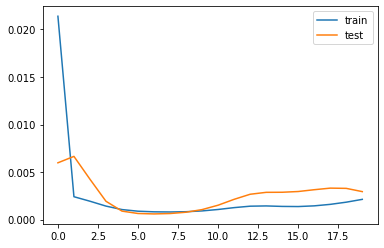

Test RMSE: 4.114
Test RMSE/std_dev: 0.531
Test MAE: 3.884


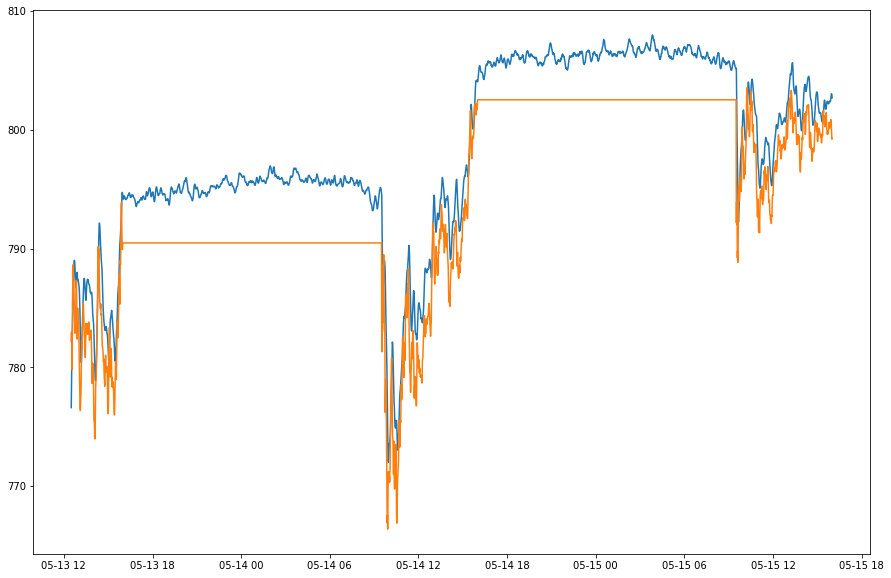

In [90]:
# load dataset
values = data.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# specify the number of lag hours
window = 270
features = 4
# frame as supervised learning
reframed = tools.series_to_supervised(scaled, window, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[-3,-2,-1]], axis=1, inplace=True)

# split into train and test sets
values = reframed.values
train_mins = len(data.loc[:'2020-05-13 08:00:00'])
train = values[:train_mins, :]
test = values[train_mins:, :]
# split into input and outputs
observations = window * features
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], window, features))
test_X = test_X.reshape((test_X.shape[0], window, features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = tensorflow.keras.Sequential()
model.add(tensorflow.keras.layers.LSTM(64, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(tensorflow.keras.layers.Dense(1))
model.compile(loss='mse', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=20, batch_size=64, validation_data=(test_X, test_y), verbose=2, shuffle=False, workers=4)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# make a prediction
y_pred = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], observations))
# invert scaling for forecast
y_pred = np.concatenate((y_pred, test_X[:, -3:]), axis=1)
y_pred = scaler.inverse_transform(y_pred)
y_pred = y_pred[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
y_actual = np.concatenate((test_y, test_X[:, -3:]), axis=1)
y_actual = scaler.inverse_transform(y_actual)
y_actual = y_actual[:,0]
# calculate RMSE
rmse = math.sqrt(mean_squared_error(y_actual, y_pred))
print('Test RMSE: %.3f' % rmse)
rmse_std = rmse/y_actual.std()
print('Test RMSE/std_dev: %.3f' % rmse_std)
mae = mean_absolute_error(y_actual, y_pred)
print('Test MAE: %.3f' % mae)

fig, ax = plt.subplots(1, figsize=(15,10))
plt.plot(data.index[-3090:], y_pred)
plt.plot(data.index[-3090:], y_actual)

# LSTM
- 64-dimensional single layer
- activation=relu
- epochs = 20
- batch size = 64
- 2 nights and 2 days of predictions

(3540, 1080) 3540 (3540,)
(3540, 270, 4) (3540,) (2610, 270, 4) (2610,)
Epoch 1/20
56/56 - 6s - loss: 0.0538 - val_loss: 0.0042
Epoch 2/20
56/56 - 5s - loss: 0.0057 - val_loss: 0.0029
Epoch 3/20
56/56 - 5s - loss: 0.0046 - val_loss: 0.0026
Epoch 4/20
56/56 - 5s - loss: 0.0037 - val_loss: 0.0023
Epoch 5/20
56/56 - 5s - loss: 0.0029 - val_loss: 0.0030
Epoch 6/20
56/56 - 5s - loss: 0.0026 - val_loss: 0.0037
Epoch 7/20
56/56 - 5s - loss: 0.0025 - val_loss: 0.0041
Epoch 8/20
56/56 - 5s - loss: 0.0024 - val_loss: 0.0042
Epoch 9/20
56/56 - 5s - loss: 0.0024 - val_loss: 0.0041
Epoch 10/20
56/56 - 5s - loss: 0.0022 - val_loss: 0.0039
Epoch 11/20
56/56 - 5s - loss: 0.0022 - val_loss: 0.0038
Epoch 12/20
56/56 - 6s - loss: 0.0020 - val_loss: 0.0034
Epoch 13/20
56/56 - 6s - loss: 0.0019 - val_loss: 0.0032
Epoch 14/20
56/56 - 6s - loss: 0.0017 - val_loss: 0.0029
Epoch 15/20
56/56 - 6s - loss: 0.0015 - val_loss: 0.0026
Epoch 16/20
56/56 - 6s - loss: 0.0014 - val_loss: 0.0023
Epoch 17/20
56/56 - 5s - 

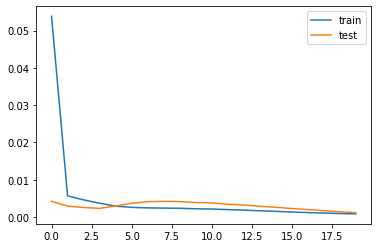

Test RMSE: 2.585
Test RMSE/std_dev: 0.349
Test MAE: 2.331


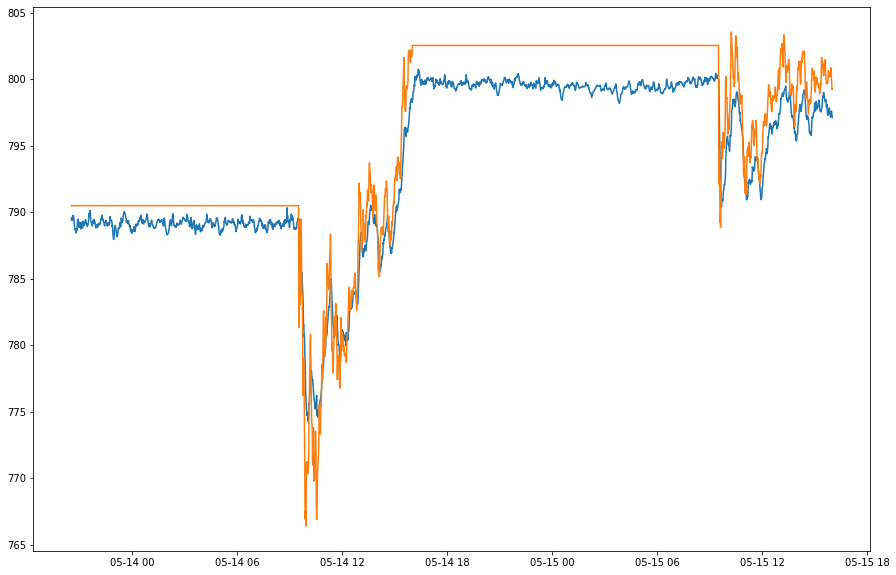

In [91]:
# load dataset
values = data.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# specify the number of lag hours
window = 270
features = 4
# frame as supervised learning
reframed = tools.series_to_supervised(scaled, window, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[-3,-2,-1]], axis=1, inplace=True)

# split into train and test sets
values = reframed.values
train_mins = len(data.loc[:'2020-05-13 16:00:00'])
train = values[:train_mins, :]
test = values[train_mins:, :]
# split into input and outputs
observations = window * features
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], window, features))
test_X = test_X.reshape((test_X.shape[0], window, features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = tensorflow.keras.Sequential()
model.add(tensorflow.keras.layers.LSTM(64, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(tensorflow.keras.layers.Dense(1))
model.compile(loss='mse', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=20, batch_size=64, validation_data=(test_X, test_y), verbose=2, shuffle=False, workers=4)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# make a prediction
y_pred = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], observations))
# invert scaling for forecast
y_pred = np.concatenate((y_pred, test_X[:, -3:]), axis=1)
y_pred = scaler.inverse_transform(y_pred)
y_pred = y_pred[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
y_actual = np.concatenate((test_y, test_X[:, -3:]), axis=1)
y_actual = scaler.inverse_transform(y_actual)
y_actual = y_actual[:,0]
# calculate RMSE
rmse = math.sqrt(mean_squared_error(y_actual, y_pred))
print('Test RMSE: %.3f' % rmse)
rmse_std = rmse/y_actual.std()
print('Test RMSE/std_dev: %.3f' % rmse_std)
mae = mean_absolute_error(y_actual, y_pred)
print('Test MAE: %.3f' % mae)

fig, ax = plt.subplots(1, figsize=(15,10))
plt.plot(data.index[-2610:], y_pred)
plt.plot(data.index[-2610:], y_actual)

# LSTM
- 128-dimensional layer, 64-dimensional layer
- activation=tanh
- 2 nights and 2 days of predictions

(3540, 1080) 3540 (3540,)
(3540, 270, 4) (3540,) (2610, 270, 4) (2610,)
Epoch 1/20
14/14 - 14s - loss: 0.0504 - val_loss: 0.0066
Epoch 2/20
14/14 - 13s - loss: 0.0270 - val_loss: 0.0130
Epoch 3/20
14/14 - 14s - loss: 0.0184 - val_loss: 0.0155
Epoch 4/20
14/14 - 14s - loss: 0.0039 - val_loss: 0.0014
Epoch 5/20
14/14 - 14s - loss: 0.0014 - val_loss: 6.7677e-04
Epoch 6/20
14/14 - 14s - loss: 0.0010 - val_loss: 4.7697e-04
Epoch 7/20
14/14 - 14s - loss: 9.5733e-04 - val_loss: 4.8274e-04
Epoch 8/20
14/14 - 14s - loss: 0.0012 - val_loss: 6.3260e-04
Epoch 9/20
14/14 - 13s - loss: 0.0014 - val_loss: 7.4428e-04
Epoch 10/20
14/14 - 13s - loss: 0.0017 - val_loss: 8.1524e-04
Epoch 11/20
14/14 - 13s - loss: 0.0020 - val_loss: 8.8319e-04
Epoch 12/20
14/14 - 14s - loss: 0.0023 - val_loss: 9.0330e-04
Epoch 13/20
14/14 - 14s - loss: 0.0025 - val_loss: 8.6728e-04
Epoch 14/20
14/14 - 14s - loss: 0.0025 - val_loss: 8.0043e-04
Epoch 15/20
14/14 - 14s - loss: 0.0023 - val_loss: 7.2355e-04
Epoch 16/20
14/14 -

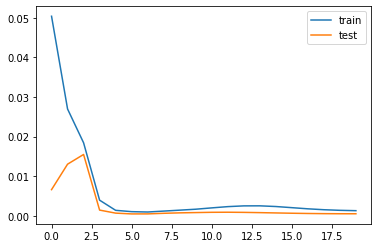

Test RMSE: 1.721
Test RMSE/std_dev: 0.232
Test MAE: 1.361


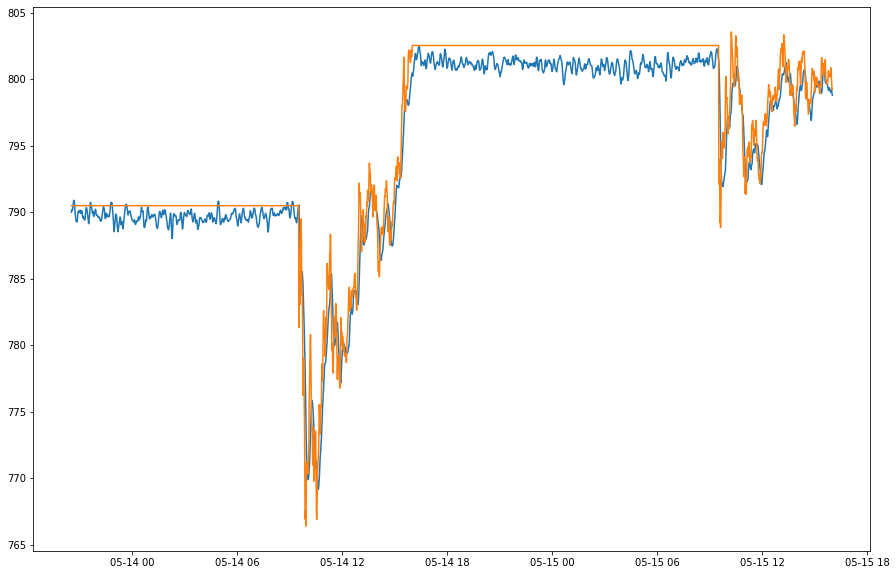

In [92]:
# load dataset
values = data.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# specify the number of lag hours
n_hours = 270
n_features = 4
# frame as supervised learning
reframed = tools.series_to_supervised(scaled, n_hours, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[-3,-2,-1]], axis=1, inplace=True)

# split into train and test sets
values = reframed.values
n_train_hours = len(data.loc[:'2020-05-13 16:00:00'])
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = tensorflow.keras.Sequential()
model.add(tensorflow.keras.layers.LSTM(128, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(tensorflow.keras.layers.LSTM(64, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(tensorflow.keras.layers.Dense(1))
model.compile(loss='mse', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=20, batch_size=256, validation_data=(test_X, test_y), verbose=2, shuffle=False, workers=4)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# make a prediction
y_pred = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], observations))
# invert scaling for forecast
y_pred = np.concatenate((y_pred, test_X[:, -3:]), axis=1)
y_pred = scaler.inverse_transform(y_pred)
y_pred = y_pred[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
y_actual = np.concatenate((test_y, test_X[:, -3:]), axis=1)
y_actual = scaler.inverse_transform(y_actual)
y_actual = y_actual[:,0]
# calculate RMSE
rmse = math.sqrt(mean_squared_error(y_actual, y_pred))
print('Test RMSE: %.3f' % rmse)
rmse_std = rmse/y_actual.std()
print('Test RMSE/std_dev: %.3f' % rmse_std)
mae = mean_absolute_error(y_actual, y_pred)
print('Test MAE: %.3f' % mae)

fig, ax = plt.subplots(1, figsize=(15,10))
plt.plot(data.index[-2610:], y_pred)
plt.plot(data.index[-2610:], y_actual)

# LSTM
- 100-dimensional single layer
- activation = tanh
- epochs = 20
- batch size = 64

(3540, 1080) 3540 (3540,)
(3540, 270, 4) (3540,) (2610, 270, 4) (2610,)
Epoch 1/20
56/56 - 9s - loss: 0.0436 - val_loss: 0.0093
Epoch 2/20
56/56 - 9s - loss: 0.0075 - val_loss: 0.0067
Epoch 3/20
56/56 - 10s - loss: 0.0052 - val_loss: 0.0082
Epoch 4/20
56/56 - 9s - loss: 0.0036 - val_loss: 0.0073
Epoch 5/20
56/56 - 8s - loss: 0.0027 - val_loss: 0.0061
Epoch 6/20
56/56 - 8s - loss: 0.0021 - val_loss: 0.0049
Epoch 7/20
56/56 - 9s - loss: 0.0017 - val_loss: 0.0036
Epoch 8/20
56/56 - 9s - loss: 0.0013 - val_loss: 0.0025
Epoch 9/20
56/56 - 9s - loss: 0.0011 - val_loss: 0.0016
Epoch 10/20
56/56 - 9s - loss: 9.6258e-04 - val_loss: 0.0010
Epoch 11/20
56/56 - 9s - loss: 9.3869e-04 - val_loss: 7.4102e-04
Epoch 12/20
56/56 - 9s - loss: 9.8397e-04 - val_loss: 6.1554e-04
Epoch 13/20
56/56 - 10s - loss: 0.0010 - val_loss: 5.3106e-04
Epoch 14/20
56/56 - 10s - loss: 0.0011 - val_loss: 4.5027e-04
Epoch 15/20
56/56 - 10s - loss: 0.0011 - val_loss: 3.8225e-04
Epoch 16/20
56/56 - 10s - loss: 0.0010 - val_l

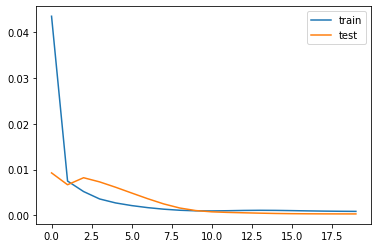

Test RMSE: 1.279
Test RMSE/std_dev: 0.173
Test MAE: 0.771


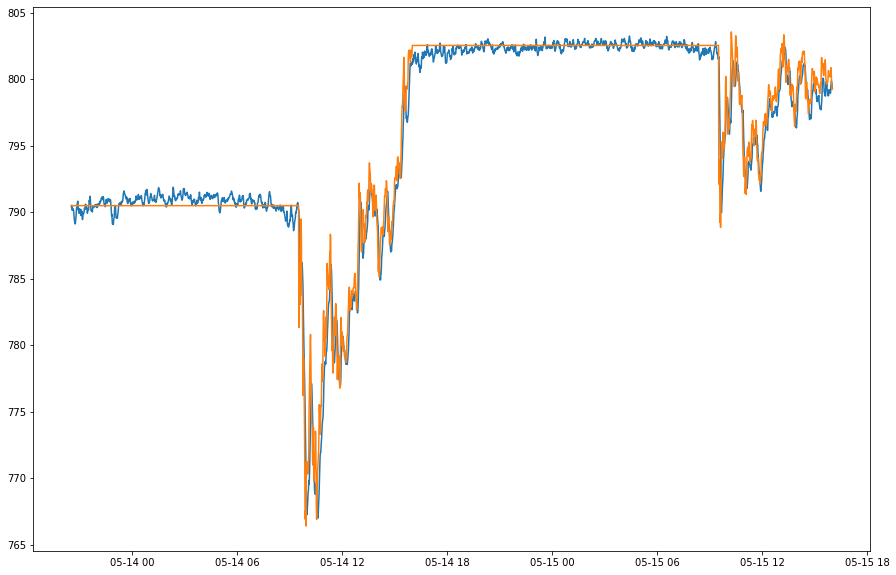

In [93]:
# load dataset
values = data.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# specify the number of lag hours
window = 270
features = 4
# frame as supervised learning
reframed = tools.series_to_supervised(scaled, window, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[-3,-2,-1]], axis=1, inplace=True)

# split into train and test sets
values = reframed.values
train_mins = len(data.loc[:'2020-05-13 16:00:00'])
train = values[:train_mins, :]
test = values[train_mins:, :]
# split into input and outputs
observations = window * features
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], window, features))
test_X = test_X.reshape((test_X.shape[0], window, features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = tensorflow.keras.Sequential()
model.add(tensorflow.keras.layers.LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(tensorflow.keras.layers.Dense(1))
model.compile(loss='mse', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=20, batch_size=64, validation_data=(test_X, test_y), verbose=2, shuffle=False, workers=4)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# make a prediction
y_pred = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], observations))
# invert scaling for forecast
y_pred = np.concatenate((y_pred, test_X[:, -3:]), axis=1)
y_pred = scaler.inverse_transform(y_pred)
y_pred = y_pred[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
y_actual = np.concatenate((test_y, test_X[:, -3:]), axis=1)
y_actual = scaler.inverse_transform(y_actual)
y_actual = y_actual[:,0]
# calculate RMSE
rmse = math.sqrt(mean_squared_error(y_actual, y_pred))
print('Test RMSE: %.3f' % rmse)
rmse_std = rmse/y_actual.std()
print('Test RMSE/std_dev: %.3f' % rmse_std)
mae = mean_absolute_error(y_actual, y_pred)
print('Test MAE: %.3f' % mae)

fig, ax = plt.subplots(1, figsize=(15,10))
plt.plot(data.index[-2610:], y_pred)
plt.plot(data.index[-2610:], y_actual)

# Convolutional LSTM
- single 2D convolutional LSTM layer
- filters = 64
- kernel_size = (2,135)
- activation = relu
- epochs = 20
- batch size = 32

(3540, 1080) 3540 (3540,)
(3540, 1, 3, 90, 4) (3540,) (2610, 1, 3, 90, 4) (2610,)
Epoch 1/20
56/56 - 67s - loss: 0.0869 - val_loss: 0.0192
Epoch 2/20
56/56 - 67s - loss: 0.0556 - val_loss: 0.0266
Epoch 3/20
56/56 - 68s - loss: 0.0182 - val_loss: 0.0139
Epoch 4/20
56/56 - 69s - loss: 0.0192 - val_loss: 0.0229
Epoch 5/20
56/56 - 73s - loss: 0.0196 - val_loss: 0.0263
Epoch 6/20
56/56 - 68s - loss: 0.0200 - val_loss: 0.0170
Epoch 7/20
56/56 - 67s - loss: 0.0165 - val_loss: 0.0103
Epoch 8/20
56/56 - 67s - loss: 0.0126 - val_loss: 0.0074
Epoch 9/20
56/56 - 67s - loss: 0.0108 - val_loss: 0.0069
Epoch 10/20
56/56 - 67s - loss: 0.0088 - val_loss: 0.0086
Epoch 11/20
56/56 - 67s - loss: 0.0078 - val_loss: 0.0066
Epoch 12/20
56/56 - 68s - loss: 0.0074 - val_loss: 0.0071
Epoch 13/20
56/56 - 67s - loss: 0.0068 - val_loss: 0.0106
Epoch 14/20
56/56 - 67s - loss: 0.0071 - val_loss: 0.0080
Epoch 15/20
56/56 - 67s - loss: 0.0068 - val_loss: 0.0088
Epoch 16/20
56/56 - 67s - loss: 0.0068 - val_loss: 0.0095

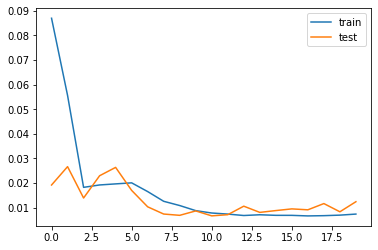

Test RMSE: 8.394
Test RMSE/std_dev: 1.133
Test MAE: 7.603


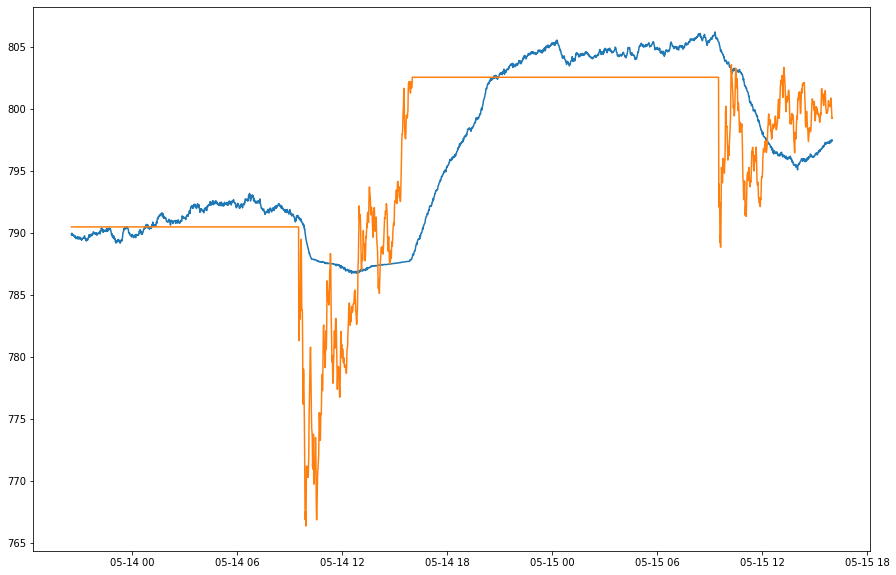

In [97]:
## load dataset
values = data.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# specify the number of lag hours
window = 270
features = 4
# frame as supervised learning
reframed = tools.series_to_supervised(scaled, window, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[-3,-2,-1]], axis=1, inplace=True)

# split into train and test sets
values = reframed.values
train_mins = len(data.loc[:'2020-05-13 16:00:00'])
train = values[:train_mins, :]
test = values[train_mins:, :]
# split into input and outputs
observations = n_hours * n_features
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1 ,3, 90, 4))
test_X = test_X.reshape((test_X.shape[0], 1, 3, 90, 4))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = tensorflow.keras.Sequential()
model.add(tensorflow.keras.layers.ConvLSTM2D(filters=128, kernel_size=(3,90), input_shape=(train_X.shape[1], 3, 90, 4)))
model.add(tensorflow.keras.layers.Dense(1))
model.compile(loss='mse', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=20, batch_size=64, validation_data=(test_X, test_y), verbose=2, shuffle=False, workers=4)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# make a prediction
y_pred = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], observations))
y_pred = y_pred.reshape(y_pred.shape[0],1)
# invert scaling for forecast
y_pred = np.concatenate((y_pred, test_X[:, -3:]), axis=1)
y_pred = scaler.inverse_transform(y_pred)
y_pred = y_pred[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
y_actual = np.concatenate((test_y, test_X[:, -3:]), axis=1)
y_actual = scaler.inverse_transform(y_actual)
y_actual = y_actual[:,0]
# calculate RMSE
rmse = math.sqrt(mean_squared_error(y_actual, y_pred))
print('Test RMSE: %.3f' % rmse)
rmse_std = rmse/y_actual.std()
print('Test RMSE/std_dev: %.3f' % rmse_std)
mae = mean_absolute_error(y_actual, y_pred)
print('Test MAE: %.3f' % mae)

fig, ax = plt.subplots(1, figsize=(15,10))
plt.plot(data.index[-2610:], inv_yhat)
plt.plot(data.index[-2610:], inv_y)